In [1]:
import torch
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import pytorch3d
import pytorch3d.io
import json
import random
import pickle
import matplotlib.pyplot as plt

In [4]:
mesh_path = './pose__01_11_gender_m_shape_624_texture_nongrey_male_0364_time_0'
depth_path = './pose__01_11_gender_m_shape_624_texture_nongrey_male_0364_time_0_angle_3_x_0.06524504004767456_y_-0.4392347379791311_z_2.3664376918793324.pkl'

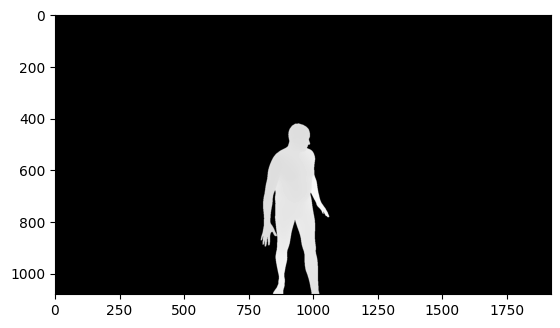

In [5]:
with open(depth_path, 'rb') as handle:
    img = pickle.load(handle)

plt.imshow(img, cmap='gray')

In [6]:
new_vertices, new_face_props, new_text_props = pytorch3d.io.load_obj(mesh_path)

/home/ashwinvaswani/anaconda3/envs/pytorch3d_prohmr/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [7]:
img_size = (1080, 1920)
height, width = img_size
row = height
col = width
fov = 60
aspect_ratio = width / height

fy = height / (2. * np.tan(fov * np.pi / 360.))
fx = width / (2. * np.tan(fov * np.pi / 360.))

cx = width / 2.0
cy = height / 2.0
v = np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)[:, :, 0]
u = np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)[:, :, 1]

img1 = img[:,:,0]
X_ = (u - cx) / fx
X_ = X_[img1 > -1]  # exclude infinity
Y_ = (v - cy) / fy 
Y_ = Y_[img1 > -1]  # exclude infinity
depth_ = img1[img1 > -1]  # exclude infinity

X = X_ * depth_ 
Y = Y_ * depth_ 
Z = depth_

pcd_np = np.stack([X,Y,Z], axis=1)

In [15]:
device = torch.device("cuda:1")
R = pytorch3d.transforms.euler_angles_to_matrix(torch.Tensor([90,180,0])/180 * np.pi, convention='XYZ').float().to(device)
T = torch.tensor(np.array([0.06524504004767456, -0.4392347379791311, 2.3664376918793324])).float().to(device)
cameras = pytorch3d.renderer.FoVPerspectiveCameras(
                    R=R.T.unsqueeze(0), T=T.unsqueeze(0), fov=60, device=device, aspect_ratio=aspect_ratio
                )
xyz_unproj_world = cameras.unproject_points(torch.Tensor(pcd_np).to(device), world_coordinates=True)


R_ = R.cpu().numpy()
R_= R_@np.array([[-1,0,0],[0,-1,0],[0,0,1]])
T_ = T.cpu().numpy()

out =((R_@(pcd_np+T_).T)).T

from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

pcd_torch = torch.Tensor(pcd_np).to(device)
try_output = torch.Tensor(out).to(device)
xyz_unproj_world = torch.Tensor(xyz_unproj_world).to(device)

if len(xyz_unproj_world.shape) < 3:
    xyz_unproj_world = xyz_unproj_world.unsqueeze(0)
    pcd_torch = pcd_torch.unsqueeze(0)
    try_output = try_output.unsqueeze(0)

rgbs = torch.ones_like(xyz_unproj_world).to(device)
if len(rgbs.shape) < 3:
    rgbs = rgbs.unsqueeze(0)
        
point_cloud_py3d_func = pytorch3d.structures.Pointclouds(points=xyz_unproj_world, features=rgbs*0.8).to(device)
point_cloud_no_rt = pytorch3d.structures.Pointclouds(points=pcd_torch, features=rgbs*0.3).to(device)
point_cloud_gt = pytorch3d.structures.Pointclouds(points=new_vertices.unsqueeze(0), features=torch.ones_like(new_vertices).unsqueeze(0)).to(device)
point_cloud_our = pytorch3d.structures.Pointclouds(points=try_output, features=rgbs*0.6).to(device)


fig2 = plot_scene({
    "figure": {
        "pointcloud_pytorch3dfunc": point_cloud_py3d_func,
        "pointcloud_gt": point_cloud_gt,
        "pointcloud_withoutRT": point_cloud_no_rt,
        "pointcloud_ours": point_cloud_our,
        "Camera": cameras,
    }
},
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    axis_args=AxisArgs(showgrid=True))
fig2.show()